In [4]:
import numpy as np

def monte_carlo_stock_price(S0=100, mu=0.08, sigma=0.2, T=1, N=252, simulations=10_000):
    dt = T / N
    prices = []

    for _ in range(simulations):
        # simulate one possible price path
        price = S0
        for _ in range(N):
            price *= np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
        prices.append(price)

    expected_price = np.mean(prices)
    return expected_price

print(monte_carlo_stock_price())


108.50295792684683


Generating historical stock data...
Training models and making predictions...
STOCK PRICE ANALYSIS SUMMARY

CURRENT PRICE: $263.17
DATA SPAN: 2023-03-09 to 2025-11-13
TOTAL TRADING DAYS: 981

RECENT PRICE MOVEMENT:
  - 1 day ago: $265.14
  - 5 days ago: $259.53
  - 30 days ago: $299.56

FUTURE PREDICTIONS (Next 30 days):
  - In 1 day: $285.68 (+8.55%)
  - In 7 days: $279.75 (+6.30%)
  - In 14 days: $266.84 (+1.39%)
  - In 30 days: $265.93 (+1.05%)

PREDICTION RANGE:
  - Minimum predicted: $261.34
  - Maximum predicted: $286.94
  - Average predicted: $270.86

Generating plots...


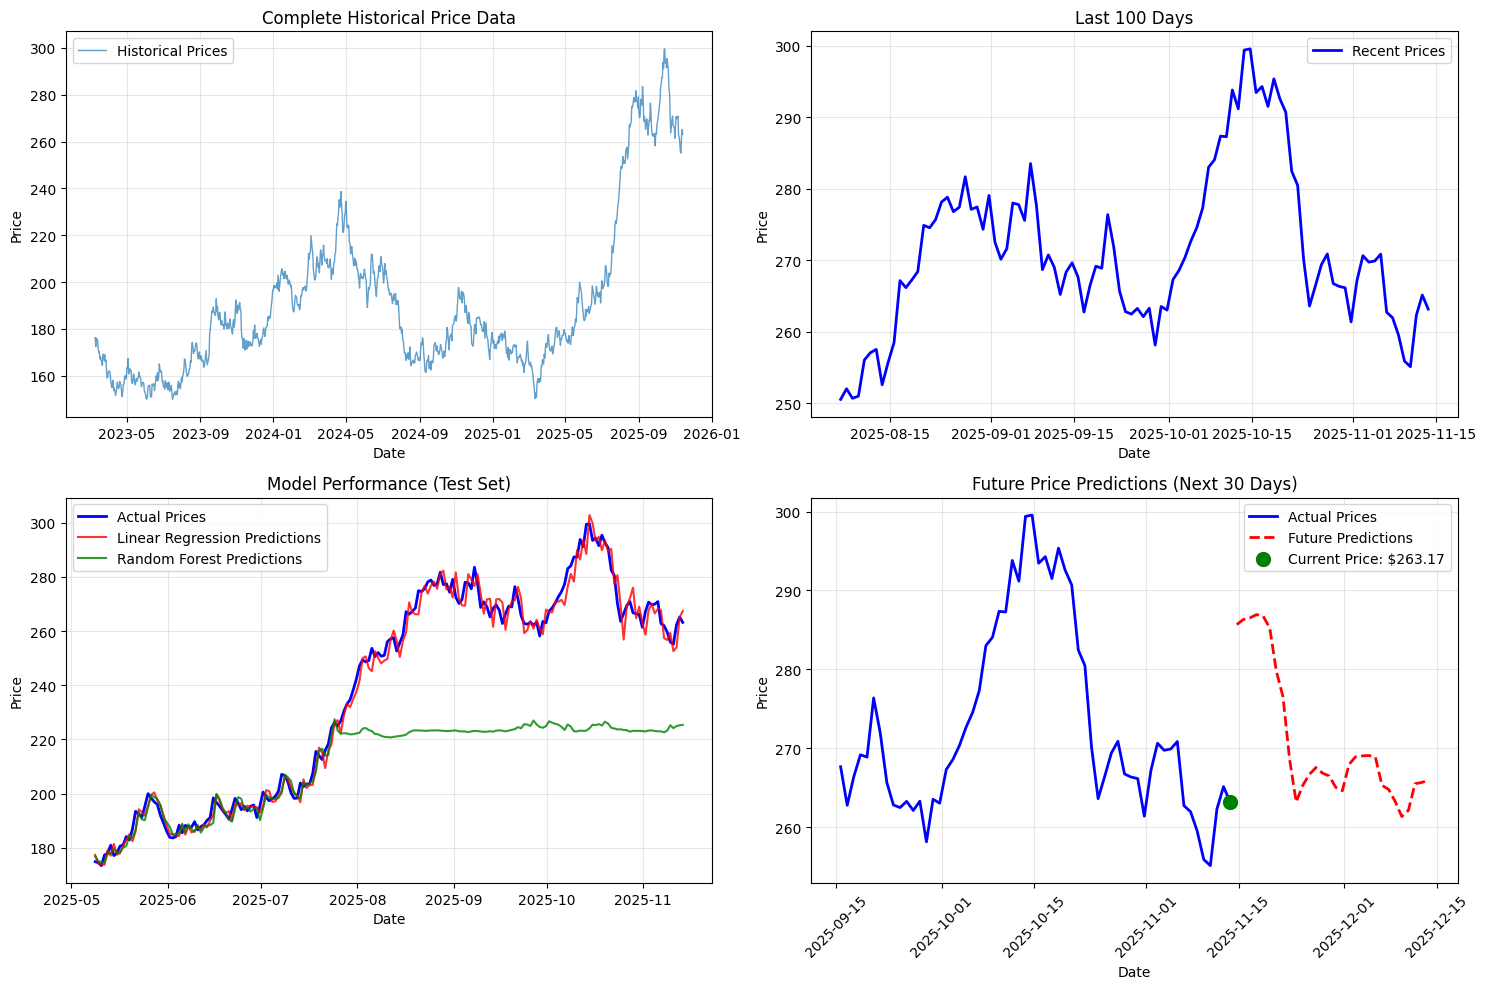

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta

def generate_historical_data(days=1000, start_price=180, volatility=0.02):
    """Generate realistic historical stock price data with trends and noise"""
    np.random.seed(42)  # For reproducible results
    
    dates = [datetime.now() - timedelta(days=x) for x in range(days)]
    dates.reverse()  # Oldest to newest
    
    prices = [start_price]
    
    # Add some realistic trends and seasonality
    for i in range(1, days):
        # Base trend + seasonal component + random noise
        trend = 0.0002  # Small upward trend
        seasonal = 0.001 * np.sin(2 * np.pi * i / 30)  # Monthly seasonality
        noise = np.random.normal(0, volatility)
        
        price_change = trend + seasonal + noise
        new_price = prices[-1] * (1 + price_change)
        prices.append(new_price)
    
    # Create DataFrame with additional features
    df = pd.DataFrame({
        'date': dates,
        'price': prices,
        'day_of_week': [d.weekday() for d in dates],
        'day_of_month': [d.day for d in dates],
        'month': [d.month for d in dates]
    })
    
    # Add technical indicators
    df['price_ma_5'] = df['price'].rolling(window=5).mean()
    df['price_ma_20'] = df['price'].rolling(window=20).mean()
    df['price_std_20'] = df['price'].rolling(window=20).std()
    df['price_momentum'] = df['price'].pct_change(periods=5)
    
    # Drop NaN values from rolling calculations
    df = df.dropna().reset_index(drop=True)
    
    return df

def prepare_features(df, lookback_days=30):
    """Prepare features for machine learning model"""
    features = ['price', 'day_of_week', 'day_of_month', 'month', 
                'price_ma_5', 'price_ma_20', 'price_std_20', 'price_momentum']
    
    X = []
    y = []
    
    for i in range(lookback_days, len(df) - 1):
        # Use past 'lookback_days' to predict next day's price
        past_features = []
        for j in range(lookback_days):
            past_features.extend([df.iloc[i - j][col] for col in features])
        
        X.append(past_features)
        y.append(df.iloc[i + 1]['price'])
    
    return np.array(X), np.array(y), df[features].values

def predict_future_prices(df, prediction_days=30, lookback_days=30):
    """Predict future stock prices using multiple models"""
    # Prepare features
    X, y, feature_columns = prepare_features(df, lookback_days)
    
    # Split data (last 20% for testing)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    predictions = {}
    for name, model in models.items():
        if name == 'Linear Regression':
            model.fit(X_train_scaled, y_train)
            test_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            test_pred = model.predict(X_test)
        
        predictions[name] = test_pred
    
    # Predict future prices using the best model (Random Forest typically works better)
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X, y)
    
    # Generate future predictions
    last_features = feature_columns[-lookback_days:]
    future_predictions = []
    current_features = last_features.flatten().reshape(1, -1)
    
    for _ in range(prediction_days):
        next_price = model_rf.predict(current_features)[0]
        future_predictions.append(next_price)
        
        # Update features for next prediction (simplified approach)
        # In a real scenario, you'd properly update all technical indicators
        new_features = feature_columns[-1].copy()
        new_features[0] = next_price  # Update price
        feature_columns = np.vstack([feature_columns, new_features])
        
        # Update current features for next prediction
        current_features = feature_columns[-lookback_days:].flatten().reshape(1, -1)
    
    return {
        'models': models,
        'test_predictions': predictions,
        'y_test': y_test,
        'future_predictions': future_predictions,
        'last_actual_price': df['price'].iloc[-1],
        'feature_columns': feature_columns
    }

def plot_predictions(df, results, prediction_days=30):
    """Plot historical data, current price, and future predictions"""
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Full historical data
    plt.subplot(2, 2, 1)
    plt.plot(df['date'], df['price'], label='Historical Prices', linewidth=1, alpha=0.7)
    plt.title('Complete Historical Price Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Recent history (last 100 days)
    plt.subplot(2, 2, 2)
    recent_days = 100
    plt.plot(df['date'].iloc[-recent_days:], df['price'].iloc[-recent_days:], 
             label='Recent Prices', linewidth=2, color='blue')
    plt.title(f'Last {recent_days} Days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Model performance on test set
    plt.subplot(2, 2, 3)
    test_dates = df['date'].iloc[-len(results['y_test']):].values
    plt.plot(test_dates, results['y_test'], label='Actual Prices', linewidth=2, color='blue')
    
    colors = ['red', 'green']
    for idx, (model_name, pred) in enumerate(results['test_predictions'].items()):
        plt.plot(test_dates, pred, label=f'{model_name} Predictions', 
                linewidth=1.5, alpha=0.8, color=colors[idx])
    
    plt.title('Model Performance (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Future predictions
    plt.subplot(2, 2, 4)
    last_date = df['date'].iloc[-1]
    future_dates = [last_date + timedelta(days=x) for x in range(1, prediction_days + 1)]
    
    # Plot last 60 days of actual data
    recent_actual_days = 60
    actual_dates = df['date'].iloc[-recent_actual_days:]
    actual_prices = df['price'].iloc[-recent_actual_days:]
    
    plt.plot(actual_dates, actual_prices, label='Actual Prices', linewidth=2, color='blue')
    plt.plot(future_dates, results['future_predictions'], 
             label='Future Predictions', linewidth=2, color='red', linestyle='--')
    
    # Mark current price
    current_price = results['last_actual_price']
    plt.scatter([last_date], [current_price], color='green', s=100, zorder=5, 
               label=f'Current Price: ${current_price:.2f}')
    
    plt.title(f'Future Price Predictions (Next {prediction_days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def print_price_summary(df, results, prediction_days=30):
    """Print summary of current and predicted prices"""
    current_price = results['last_actual_price']
    
    print("=" * 60)
    print("STOCK PRICE ANALYSIS SUMMARY")
    print("=" * 60)
    
    print(f"\nCURRENT PRICE: ${current_price:.2f}")
    print(f"DATA SPAN: {df['date'].iloc[0].strftime('%Y-%m-%d')} to {df['date'].iloc[-1].strftime('%Y-%m-%d')}")
    print(f"TOTAL TRADING DAYS: {len(df)}")
    
    print(f"\nRECENT PRICE MOVEMENT:")
    print(f"  - 1 day ago: ${df['price'].iloc[-2]:.2f}")
    print(f"  - 5 days ago: ${df['price'].iloc[-6]:.2f}")
    print(f"  - 30 days ago: ${df['price'].iloc[-31]:.2f}")
    
    print(f"\nFUTURE PREDICTIONS (Next {prediction_days} days):")
    future_predictions = results['future_predictions']
    for i, (days, price) in enumerate(zip([1, 7, 14, 30], 
                                         [future_predictions[0], future_predictions[6], 
                                          future_predictions[13], future_predictions[29]])):
        change = ((price - current_price) / current_price) * 100
        print(f"  - In {days} day{'s' if days > 1 else ''}: ${price:.2f} ({change:+.2f}%)")
    
    print(f"\nPREDICTION RANGE:")
    min_pred = min(future_predictions)
    max_pred = max(future_predictions)
    print(f"  - Minimum predicted: ${min_pred:.2f}")
    print(f"  - Maximum predicted: ${max_pred:.2f}")
    print(f"  - Average predicted: ${np.mean(future_predictions):.2f}")

# Main execution
if __name__ == "__main__":
    # Generate historical data
    print("Generating historical stock data...")
    historical_data = generate_historical_data(days=1000, start_price=180, volatility=0.015)
    
    # Make predictions
    print("Training models and making predictions...")
    results = predict_future_prices(historical_data, prediction_days=30, lookback_days=30)
    
    # Display results
    print_price_summary(historical_data, results)
    
    # Plot results
    print("\nGenerating plots...")
    plot_predictions(historical_data, results)